In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from __future__ import division

from random import gauss
import math

import pymc as pm

## Multiplayer TrueSkill Implementation

First we are going to simulate some matches between N players

In [118]:
N = 8

player_skill = np.random.randn(N)

We assign the players some random skills.

In [119]:
player_skill

array([ 0.14203934,  0.39104567, -0.32783294, -1.02282213,  0.4337989 ,
        0.69600785,  0.50098572, -0.01089866])

In [130]:
match_outcomes = []
player_points = np.zeros_like(player_skill)

for _ in range(10):
    for i in range(len(player_skill)):
        for j in range(len(player_skill)):
            if i == j:
                continue
            perf_i, perf_j = gauss(player_skill[i], 0.5), gauss(player_skill[j], 0.5)
            outcome = 1 if perf_i > perf_j else 2
            if math.fabs(perf_i - perf_j) < 0.2:
                outcome = 0
            match_outcomes.append([i, j, outcome])
            player_points[i] += 1
            player_points[j] += 1
            if outcome == 1:
                player_points[i] += 2
                player_points[j] -= 1
            elif outcome == 0:
                player_points[i] -= 1
                player_points[j] += 2

This is the standings after 10 seasons of everybody playing against everybody. Player 3 is clearly worst, and Player 5 is best, but players 1, 4 and 6 are also close (both in score and skill) 

In [163]:
sorted(zip(player_points, player_skill, range(8)), reverse=True)

[(231.0, 0.69600784995700582, 5),
 (227.0, 0.39104566560548742, 1),
 (221.0, 0.43379889692932927, 4),
 (218.0, 0.50098571779077916, 6),
 (169.0, 0.14203933776999556, 0),
 (169.0, -0.01089865923963319, 7),
 (127.0, -0.32783293640223726, 2),
 (78.0, -1.0228221263619006, 3)]

In [132]:
match_outcomes = np.array(match_outcomes)

The match outcomes look like this [first_player, second_player, outcome]. Outcome is 0 if draw, 1 if first player wins, 2 if second player wins

In [166]:
match_outcomes[:10]

array([[0, 1, 2],
       [0, 2, 1],
       [0, 3, 1],
       [0, 4, 2],
       [0, 5, 2],
       [0, 6, 1],
       [0, 7, 2],
       [1, 0, 1],
       [1, 2, 1],
       [1, 3, 1]])

In [167]:
match_outcomes.shape

(560, 3)

In [139]:
matches = match_outcomes[:,:2].astype(int)

mu = pm.Normal('mu', mu=0, tau=1/9)
sd = pm.Gamma('sd', 1, 1)

skill = pm.Normal('skill', mu=mu, tau=1/(sd**2), size=N)

@pm.deterministic
def p1wins(skill=skill):
    # compute the difference in skill between players
    d = skill[matches[:, 0]] - skill[matches[:, 1]]
    # compute the probability of the first player win (using the logistic function)
    p = 1.0 / (1 + np.exp(-d))
    # epsilon is the probability of a draw (decreases exponentially as p is further from 0.5)
    epsilon = np.exp(-15*(np.abs(p-0.5))) + 1e-6
    #return the probability of all three outcomes [draw, p1win, p2win]
    return np.vstack((np.zeros_like(p) + epsilon, p - epsilon/2, 1-p-epsilon/2)).T

# observed categorical variable (corresponding to the third column of match_outcomes)
outcome = pm.Categorical('outcome', p=p1wins, value=list(match_outcomes[:,2]), observed=True)

model = pm.Model([mu, sd, skill, p1wins, outcome])
mcmc = pm.MCMC(model)
mcmc.sample(20000)

 [-----------------100%-----------------] 20000 of 20000 complete in 5.7 sec

We plot the posterior distributions of skill for each player. As in our dataset, Player 3 is by far the worst, and Player 5 is the best.

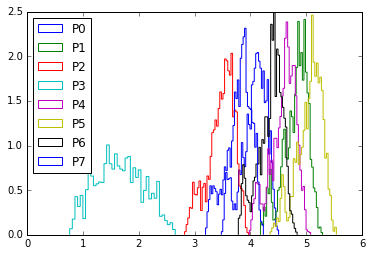

In [140]:
hist(mcmc.trace('skill')[10000:,0], 40, histtype='step', normed=True, label='P0');
hist(mcmc.trace('skill')[10000:,1], 40, histtype='step', normed=True, label='P1');
hist(mcmc.trace('skill')[10000:,2], 40, histtype='step', normed=True, label='P2');
hist(mcmc.trace('skill')[10000:,3], 40, histtype='step', normed=True, label='P3');
hist(mcmc.trace('skill')[10000:,4], 40, histtype='step', normed=True, label='P4');
hist(mcmc.trace('skill')[10000:,5], 40, histtype='step', normed=True, label='P5');
hist(mcmc.trace('skill')[10000:,6], 40, histtype='step', normed=True, label='P6');
hist(mcmc.trace('skill')[10000:,7], 40, histtype='step', normed=True, label='P7');
legend(loc='best');

Now we simulate a season from our posterior skill distributions

In [170]:
sim_matches = []
sim_points = np.zeros_like(player_points)


for i in range(len(player_skill)):
    for j in range(len(player_skill)):
        if i == j:
            continue
        skill_i, skill_j = np.mean(mcmc.trace('skill')[10000:,i]), np.mean(mcmc.trace('skill')[10000:,j])
        sd = np.mean(mcmc.trace('sd')[10000:])
        perf_i, perf_j = gauss(skill_i, sd), gauss(skill_j, sd)
        outcome = 1 if skill_i > skill_j else 2
        if np.abs(perf_i - perf_j) < 0.2:
            outcome = 0
        sim_points[i] += 1
        sim_points[j] += 1
        if outcome == 1:
            sim_points[i] += 2
            sim_points[j] -= 1
        elif outcome == 2:
            sim_points[i] -= 1
            sim_points[j] += 2
        sim_matches.append([i, j, outcome])

The standings:

In [171]:
sorted(zip(sim_points, player_skill, range(N)), reverse=True)

[(36.0, 0.69600784995700582, 5),
 (34.0, 0.39104566560548742, 1),
 (31.0, 0.43379889692932927, 4),
 (24.0, 0.50098571779077916, 6),
 (19.0, 0.14203933776999556, 0),
 (14.0, -0.01089865923963319, 7),
 (6.0, -0.32783293640223726, 2),
 (0.0, -1.0228221263619006, 3)]

And the matches [P1, P2, outcome]:

In [173]:
sim_matches

[[0, 1, 2],
 [0, 2, 1],
 [0, 3, 1],
 [0, 4, 2],
 [0, 5, 2],
 [0, 6, 2],
 [0, 7, 1],
 [1, 0, 1],
 [1, 2, 1],
 [1, 3, 1],
 [1, 4, 1],
 [1, 5, 2],
 [1, 6, 1],
 [1, 7, 1],
 [2, 0, 2],
 [2, 1, 2],
 [2, 3, 1],
 [2, 4, 2],
 [2, 5, 2],
 [2, 6, 2],
 [2, 7, 2],
 [3, 0, 2],
 [3, 1, 2],
 [3, 2, 2],
 [3, 4, 2],
 [3, 5, 2],
 [3, 6, 2],
 [3, 7, 2],
 [4, 0, 1],
 [4, 1, 2],
 [4, 2, 1],
 [4, 3, 1],
 [4, 5, 0],
 [4, 6, 1],
 [4, 7, 1],
 [5, 0, 0],
 [5, 1, 1],
 [5, 2, 1],
 [5, 3, 1],
 [5, 4, 1],
 [5, 6, 1],
 [5, 7, 0],
 [6, 0, 1],
 [6, 1, 2],
 [6, 2, 1],
 [6, 3, 1],
 [6, 4, 2],
 [6, 5, 2],
 [6, 7, 1],
 [7, 0, 2],
 [7, 1, 0],
 [7, 2, 1],
 [7, 3, 1],
 [7, 4, 2],
 [7, 5, 2],
 [7, 6, 2]]